# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from math import ceil
import statsmodels.api as sm
import pylab
import warnings
from tqdm import tqdm_notebook
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})

%matplotlib inline

# data generation

In [240]:
population_size = 20000
potential_weight, potential_mu = 0.6, 1700                
regular_weight, regular_mu = 0.4, 2450
potential_size = int(potential_weight * population_size)  
regular_size = int(regular_weight * population_size)      


potential_dist = pd.DataFrame({'purchases' : np.random.exponential(scale=potential_mu, size=potential_size),
                               'strata' : 'potential'})

regular_dist = pd.DataFrame({'purchases' : np.random.exponential(scale=regular_mu, size=regular_size),
                               'strata' : 'regular'})


pooled_data = pd.concat([potential_dist, regular_dist]).reset_index().drop('index', axis=1)
pooled_data['purchases'] = pooled_data['purchases'].astype('int')

pooled_data.head()

,purchases,strata
0,1617,potential
1,365,potential
2,1888,potential
3,1361,potential
4,642,potential


In [241]:
pooled_data.groupby('strata').agg(['mean', 'var', 'count'])

purchases                     
                  mean           var  count
strata                                     
potential  1731.545167  3.016136e+06  12000
regular    2426.291000  5.986707e+06   8000

In [243]:
def ttest(a,b):
    
    a_mu, b_mu = np.mean(a), np.mean(b)
    a_var, b_var = np.var(a), np.var(b)
    
    delta_mu = b_mu - a_mu
    pooled_var = a_var / len(a) + b_var / len(b)
    
    T_statistic = delta_mu / np.sqrt(pooled_var)
    pvalue = (1 - stats.norm.cdf(abs(T_statistic))) * 2
    
    return pvalue, delta_mu

# AA test on existing data and checking p-value distribution under H0

1-st type error: 0.053


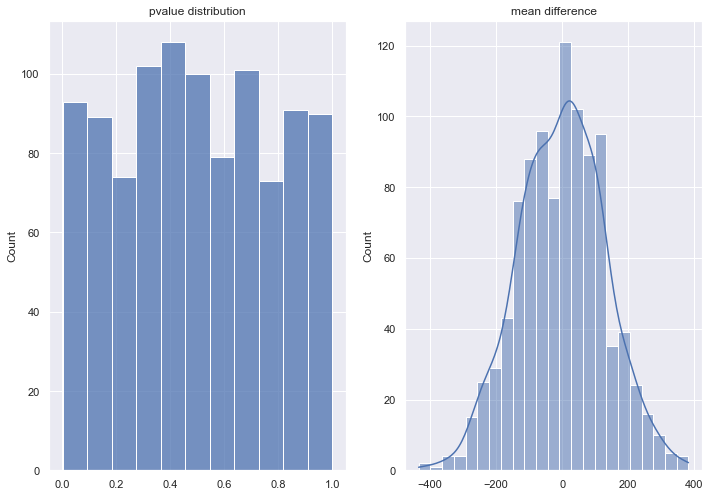

In [247]:
sns.set(rc={'figure.figsize':(11.7,8.27)})


N = 1000
first_type_error_random = []
random_delta_AA = []
alpha = 0.05
mde = 100


for i in range(N):
    
    control, treatment = np.random.choice(pooled_data['purchases'], (2, 500), replace=False)
    pvalue, delta = ttest(control, treatment)
    first_type_error_random.append(pvalue)
    random_delta_AA.append(delta)

print(f'1-st type error: {(pd.Series(first_type_error_random) < alpha).sum() / N}')


fig, axes = plt.subplots(1,2)
sns.histplot(first_type_error_random, ax=axes[0]).set_title('pvalue distribution')
sns.histplot(random_delta_AA, kde=True,ax=axes[1]).set_title('mean difference')
plt.show()

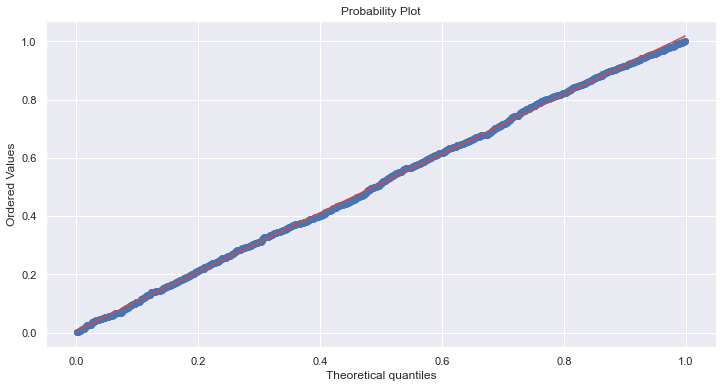

In [248]:
plt.figure(figsize=(12,6))
stats.probplot(first_type_error, dist="uniform", plot=pylab)
plt.show()

## it turns out main assumptions are met to use the t-test:
 - target metric is distributed normaly
 - p-value distribution under H0 is uniform and it control probability of I type error
 

# sample size evaluation per group

In [249]:
def get_sample_size(control_var, treatment_var, alpha=0.05, beta=0.3, mde=100):
    
    Z_alpha = stats.norm.ppf(1 - alpha/2)
    Z_beta = stats.norm.ppf(1 - beta)
    sample_size = int(np.ceil((Z_alpha + Z_beta)**2 * (control_var + treatment_var) / (mde**2)))
    
    return sample_size

In [253]:
population_mean, population_var = np.mean(pooled_data), np.var(pooled_data)
expected_mean, expected_var = population_mean + mde, population_var

sample_size = get_sample_size(population_var, expected_var)
print(f'sample size per group : {sample_size}')

sample size per group : 5333


# checking that at received sample size we will have previosly denoted probability of II type error  

In [255]:
second_type_error_random = []

for i in range(N):
    
    control = np.random.exponential(scale=population_mean, size=sample_size)
    treatment = np.random.exponential(scale=expected_mean, size=sample_size)
    pvalue, _ = ttest(control, treatment)
    second_type_error_random.append(pvalue >= alpha)
    
print(f'II type error : {np.mean(second_type_error_random)}')

II type error : 0.29


# simple random sampling

In [258]:
def get_random_sampling(mde=0):
    
    control, treatment = np.random.choice(pooled_data['purchases'], (2, sample_size), replace=False)
    treatment = treatment + mde
    
    return control, treatment

# A/B with random sampling

In [264]:
second_type_error_random = []
random_delta_AB = []

for i in range (N):
    
    control, treatment = get_random_sampling(mde)
    pvalue, delta = ttest(control, treatment)
    
    second_type_error_random.append(pvalue >= alpha)
    random_delta_AB.append(delta)
    
print(f'II type error at random sampling : {np.mean(second_type_error_random)}')

II type error at random sampling : 0.305


# stratified sampling

In [265]:
def get_stratified_sample(strats_param, mde=0):
    
    control, treatment = pd.DataFrame(), pd.DataFrame()

    for strata, (size, data) in strats_param.items():

        control = control.append(pd.DataFrame({'strata' : strata,
                                           'purchases' : data.sample(size, replace = False)}))

        treatment = treatment.append(pd.DataFrame({'strata' : strata,
                                               'purchases' : data.sample(size, replace = False)}))


    treatment['purchases'] = treatment['purchases'] + mde

    return control, treatment

In [267]:
N_potential = int(potential_weight * sample_size)
N_regular = int(regular_weight * sample_size)

potential_data = pooled_data[pooled_data['strata'] == 'potential']['purchases']
regular_data = pooled_data[pooled_data['strata'] == 'regular']['purchases']

strats_param = {'potential' : (N_potential, potential_data),
                'regular' : (N_regular, regular_data)}

# A/A with stratified sampling

In [268]:
first_type_error_stratified = []
stratified_delta_AA = []


for i in tqdm_notebook(range(N)):
   
    control, treatment = get_stratified_sample(strats_param)
    pvalue, delta = ttest(control['purchases'], treatment['purchases'])
    
    first_type_error_stratified.append(pvalue < alpha)
    delta_list_statified.append(delta)
                                       
print(f'I second type error at stratified sampling : {np.mean(first_type_error_stratified)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

I second type error at stratified sampling : 0.017


# A/B with statified sampling

In [270]:
second_type_error_stratified = []
stratified_delta_AB = []


for i in tqdm_notebook(range(N)):
   
    control, treatment = get_stratified_sample(strats_param, mde)
    pvalue, delta = ttest(control['purchases'], treatment['purchases'])
    
    second_type_error_stratified.append(pvalue >= alpha)
    stratified_delta_AB.append(delta)
                                       
print(f'II second type error at stratified sampling : {np.mean(second_type_error_stratified)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

II second type error at stratified sampling : 0.26


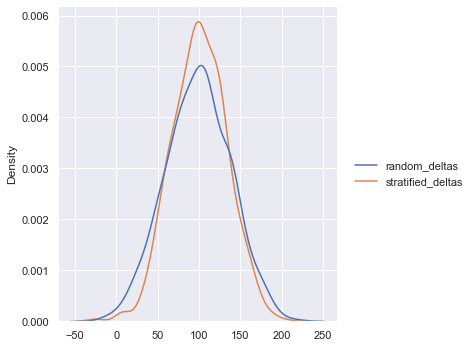

In [273]:
sns.displot(
    {'random_deltas': random_delta_AB, 'stratified_deltas': stratified_delta_AB},
    kind='kde')
plt.show()

# How we can see stratified sampling decreases I and II type errors, variance, which very well. But I type error is not controlled on claimed significance level. It is not a very good. Also our ttest do not knows we use stratified sampling instead random. To return out test to needed significance level we will be helped stratified mean

In [300]:
def get_statified_params(df_a, df_b, weights):
    
    a_strat_mu = (df_a.groupby('strata')['purchases'].mean() * weights).sum()
    b_strat_mu = (df_b.groupby('strata')['purchases'].mean() * weights).sum()
    
    a_strat_var = (df_a.groupby('strata')['purchases'].var() * weights).sum()
    b_strat_var = (df_b.groupby('strata')['purchases'].var() * weights).sum() 
    
    return a_strat_mu, a_strat_var, b_strat_mu, b_strat_var


def stratified_ttest(df_a, df_b, weights):
    
    a_mu, a_var, b_mu, b_var = get_statified_params(df_a, df_b, weights)
     
    delta_mu = b_mu - a_mu
    pooled_var = a_var/len(df_a) + b_var/len(df_b)
    
    T_statistic = delta_mu / np.sqrt(pooled_var)
    pvalue = (1 - stats.norm.cdf(abs(T_statistic))) * 2
    
    return pvalue, delta_mu

In [308]:
first_type_errors_stratified = []
second_type_errors_stratified = []
stratified_delta_AA = []
stratified_delta_AB = []

weights = pd.Series({'potential' : potential_weight,
                     'regular' : regular_weight})


for i in tqdm_notebook(range(1000)):
    
    control_AA, treatment_AA = get_stratified_sample(strats_param)
    control_AB, treatment_AB = get_stratified_sample(strats_param, mde)
    
    pvalue_AA, delta_AA = stratified_ttest(control_AA, treatment_AA, weights)
    pvalue_AB, delta_AB = stratified_ttest(control_AB, treatment_AB, weights)
    
    first_type_errors_stratified.append(pvalue_AA < alpha)
    second_type_errors_stratified.append(pvalue_AB >= alpha)
    
    stratified_delta_AA.append(delta_AA)
    stratified_delta_AB.append(delta_AB)
    
print(f'I second type error at stratified sampling : {np.mean(first_type_errors_stratified)}')
print(f'II second type error at stratified sampling : {np.mean(second_type_errors_stratified)}')

  0%|          | 0/1000 [00:00<?, ?it/s]

I second type error at stratified sampling : 0.02
II second type error at stratified sampling : 0.256


# Summarize about stratification

## Stratified sampling allows to reduce II type errors and variance. All together it increase test sensitivity and hence the test power to. I am indeed have been trying figure out why my I type error do not return to previously denoted significance level at 0.05. If our power increases we can detect more smaller minimum detectable effect (mde) or we can decrease sample size to save time is equal a money in most cases. I mean we can the reducing sample size and at saving previously claimed ed the power

# All this is possible thanks to additional data. In our case we know both distribution and weight of each stratas.

# But which if, we do not know any additional information about our data? Bootstrap method will help us. It is meaning is we present sampled data as whole population and then we start random withdraw data with replacement. As a result we can estimate various statistics and  we can build a confidence intervals for them as well

## what i gonna do:

 - I take data i used previously and then random split into two groups. Then i will add an effect to one group which is equal 100
 - Further i random withdraw two samples from two groups respectively
 - Calculate needed statistics in both samples. In our case is mean
 - Figure out difference between them
 - Save the result
 - Repeat this algorithm many times
 - build confidence interval at given alpha. i use alpha is equal 0.05

In [361]:
N = 10000

population_mean, population_var = np.mean(pooled_data), np.var(pooled_data)
expected_mean, expected_var = population_mean + mde, population_var
sample_size = get_sample_size(population_var, expected_var)

In [362]:
bootstrap_diff = []

for i in tqdm_notebook(range(N)):
    
    control, treatment = np.random.choice(pooled_data['purchases'], (2, sample_size), replace=False)
    treatment += 100
    
    control_mu, treatment_mu = np.mean(control), np.mean(treatment)
    diff = treatment_mu - control_mu
    
    bootstrap_diff.append(diff)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [369]:
borders = np.percentile(bootstrap_diff, [2.5, 97.5])

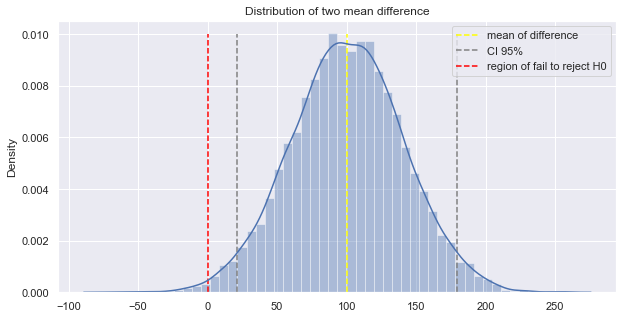

In [382]:
plt.figure(figsize=(10,5))
sns.distplot(bootstrap_diff)
plt.title('Distribution of two mean difference')
plt.vlines(np.mean(borders), ymin=0, ymax=0.01, linestyles='--', color='yellow', label='mean of difference')
plt.vlines(borders, ymin=0, ymax=0.01, linestyles='--', color='grey', label='CI 95%')
plt.vlines(0, ymin=0, ymax=0.01, linestyles='--', color='red', label='region of fail to reject H0')
plt.legend()
plt.show()

#  Summarize about Bootstrap

## As we can see, zero does not fall to our 95% confidence interval and it is meaning that we can reject H0 about of equality of means at probability of being wrong is equal alpha, i.e 5%

# The main lack of that method is it is take a long time at enough big data size